In [1]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [2]:
for no in ['A','B','C','D']:
    tracks[no] = tracks[no][['date', 'キロ程', '高低左']]

In [29]:
%matplotlib inline

In [4]:
import datetime
from tqdm import tqdm
import random
import sys

In [5]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [6]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [7]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                                                            df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [9]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [10]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [11]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [12]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [14]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [15]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [16]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

In [17]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [18]:
summarys = {}
for no in ['A','B','C','D']:
#     summarys[no] = pd.read_csv("summary12_" + no + "_lgbm.csv", index_col=0)
    summarys[no] = pd.read_csv("summary12_" + no + ".csv", index_col=0)

In [19]:
import pandas_profiling as pdp

In [20]:
pdp.ProfileReport(summarys['A'])

Number of variables,7
Number of observations,27906
Total Missing (%),0.2%
Total size in memory,1.7 MiB
Average record size in memory,64.0 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [21]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == -100, '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

# LightGBM

In [23]:
summarys['D']

,路線,キロ程,傾き,切片,標本標準偏差,測定回数,データ数
0,D,10000,-0.001744,-0.670,0.286509,211,54
1,D,10001,0.003181,-0.450,0.356374,211,44
2,D,10002,0.002455,0.340,0.330879,212,47
3,D,10003,0.001804,1.275,0.193736,213,36
4,D,10004,0.003191,1.510,0.361624,212,40
5,D,10005,-0.000062,0.730,0.528602,213,42
6,D,10006,-0.001089,-0.400,0.404685,213,34
7,D,10007,0.002328,-1.035,0.409819,213,41
8,D,10008,0.000415,-0.315,0.872255,214,43
9,D,10009,-0.001869,1.695,1.043773,213,70


In [24]:
from numpy.random import normal

In [25]:
train = summarys['D']['傾き'].values
train = pd.DataFrame({'slope': train})

# for i in range(1):
#     train[f'lag{i+1}'] = train['slope'].shift(i+1)
#     train[f'lag{-i-1}'] = train['slope'].shift(-i-1)
# train['dif'] = train['slope'] - train['lag1']
# lagdif = train['dif'].shift(1)
# train['difdif'] = train['dif'] - lagdif

lag = train['slope'].shift(1)
train['dif'] = train['slope'] - lag
# diflag = train['dif'].shift(1)
# train['difdif'] = train['dif'] - diflag

lag_inv = train['slope'].shift(-1)
train['dif_inv'] = train['slope'] - lag_inv
# diflag_inv = train['dif'].shift(-1)
# train['difdif_inv'] = train['dif'] - diflag_inv

train['maen'] = (lag + lag_inv)*0.5

#     train[f'lag{-i-1}'] = train['slope'].shift(-i-1)

# size = len(train.index)*len(train.columns)
# eps = normal(0, 0.001, [len(train.index), len(train.columns)])
# train = train + eps

In [26]:
train

,slope,dif,dif_inv,maen
0,-0.001744,NaN,-0.004925,NaN
1,0.003181,0.004925,0.000726,0.000355
2,0.002455,-0.000726,0.000651,0.002492
3,0.001804,-0.000651,-0.001387,0.002823
4,0.003191,0.001387,0.003253,0.000871
5,-0.000062,-0.003253,0.001027,0.001051
6,-0.001089,-0.001027,-0.003417,0.001133
7,0.002328,0.003417,0.001913,-0.000337
8,0.000415,-0.001913,0.002284,0.000229
9,-0.001869,-0.002284,-0.006524,0.002535


In [27]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

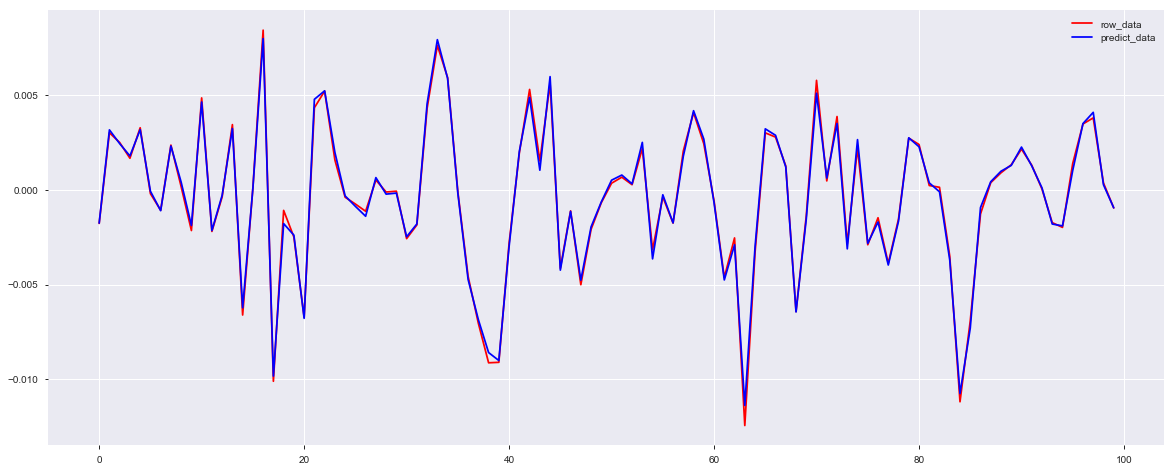

0.007099686373557964

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:100])), train_pred[:100], color="r", label="row_data")
plt.plot(range(len(y_train[:100])), y_train[:100], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

Text(0.5, 1.0, 'kilo: 10000,  slope: -0.0017440160041828714')

Text(0.5, 1.0, 'kilo: 10001,  slope: 0.003180899837540188')

Text(0.5, 1.0, 'kilo: 10002,  slope: 0.0024547966562280072')

Text(0.5, 1.0, 'kilo: 10003,  slope: 0.0018037009704952726')

Text(0.5, 1.0, 'kilo: 10004,  slope: 0.003190939742148875')

Text(0.5, 1.0, 'kilo: 10005,  slope: -6.17322018070355e-05')

Text(0.5, 1.0, 'kilo: 10006,  slope: -0.0010890669977987244')

Text(0.5, 1.0, 'kilo: 10007,  slope: 0.0023275833234509802')

Text(0.5, 1.0, 'kilo: 10008,  slope: 0.00041476388093046964')

Text(0.5, 1.0, 'kilo: 10009,  slope: -0.0018694961512733808')

Text(0.5, 1.0, 'kilo: 10010,  slope: 0.004654242125209354')

Text(0.5, 1.0, 'kilo: 10011,  slope: -0.0021398590215801747')

Text(0.5, 1.0, 'kilo: 10012,  slope: -0.0002757520866353828')

Text(0.5, 1.0, 'kilo: 10013,  slope: 0.003248533182478802')

Text(0.5, 1.0, 'kilo: 10014,  slope: -0.006221220848355575')

Text(0.5, 1.0, 'kilo: 10015,  slope: 9.639944874799004e-05')

Text(0.5, 1.0, 'kilo: 10016,  slope: 0.008001377764809678')

Text(0.5, 1.0, 'kilo: 10017,  slope: -0.009829949757883014')

Text(0.5, 1.0, 'kilo: 10018,  slope: -0.00177344597693004')

Text(0.5, 1.0, 'kilo: 10019,  slope: -0.002383436549917309')

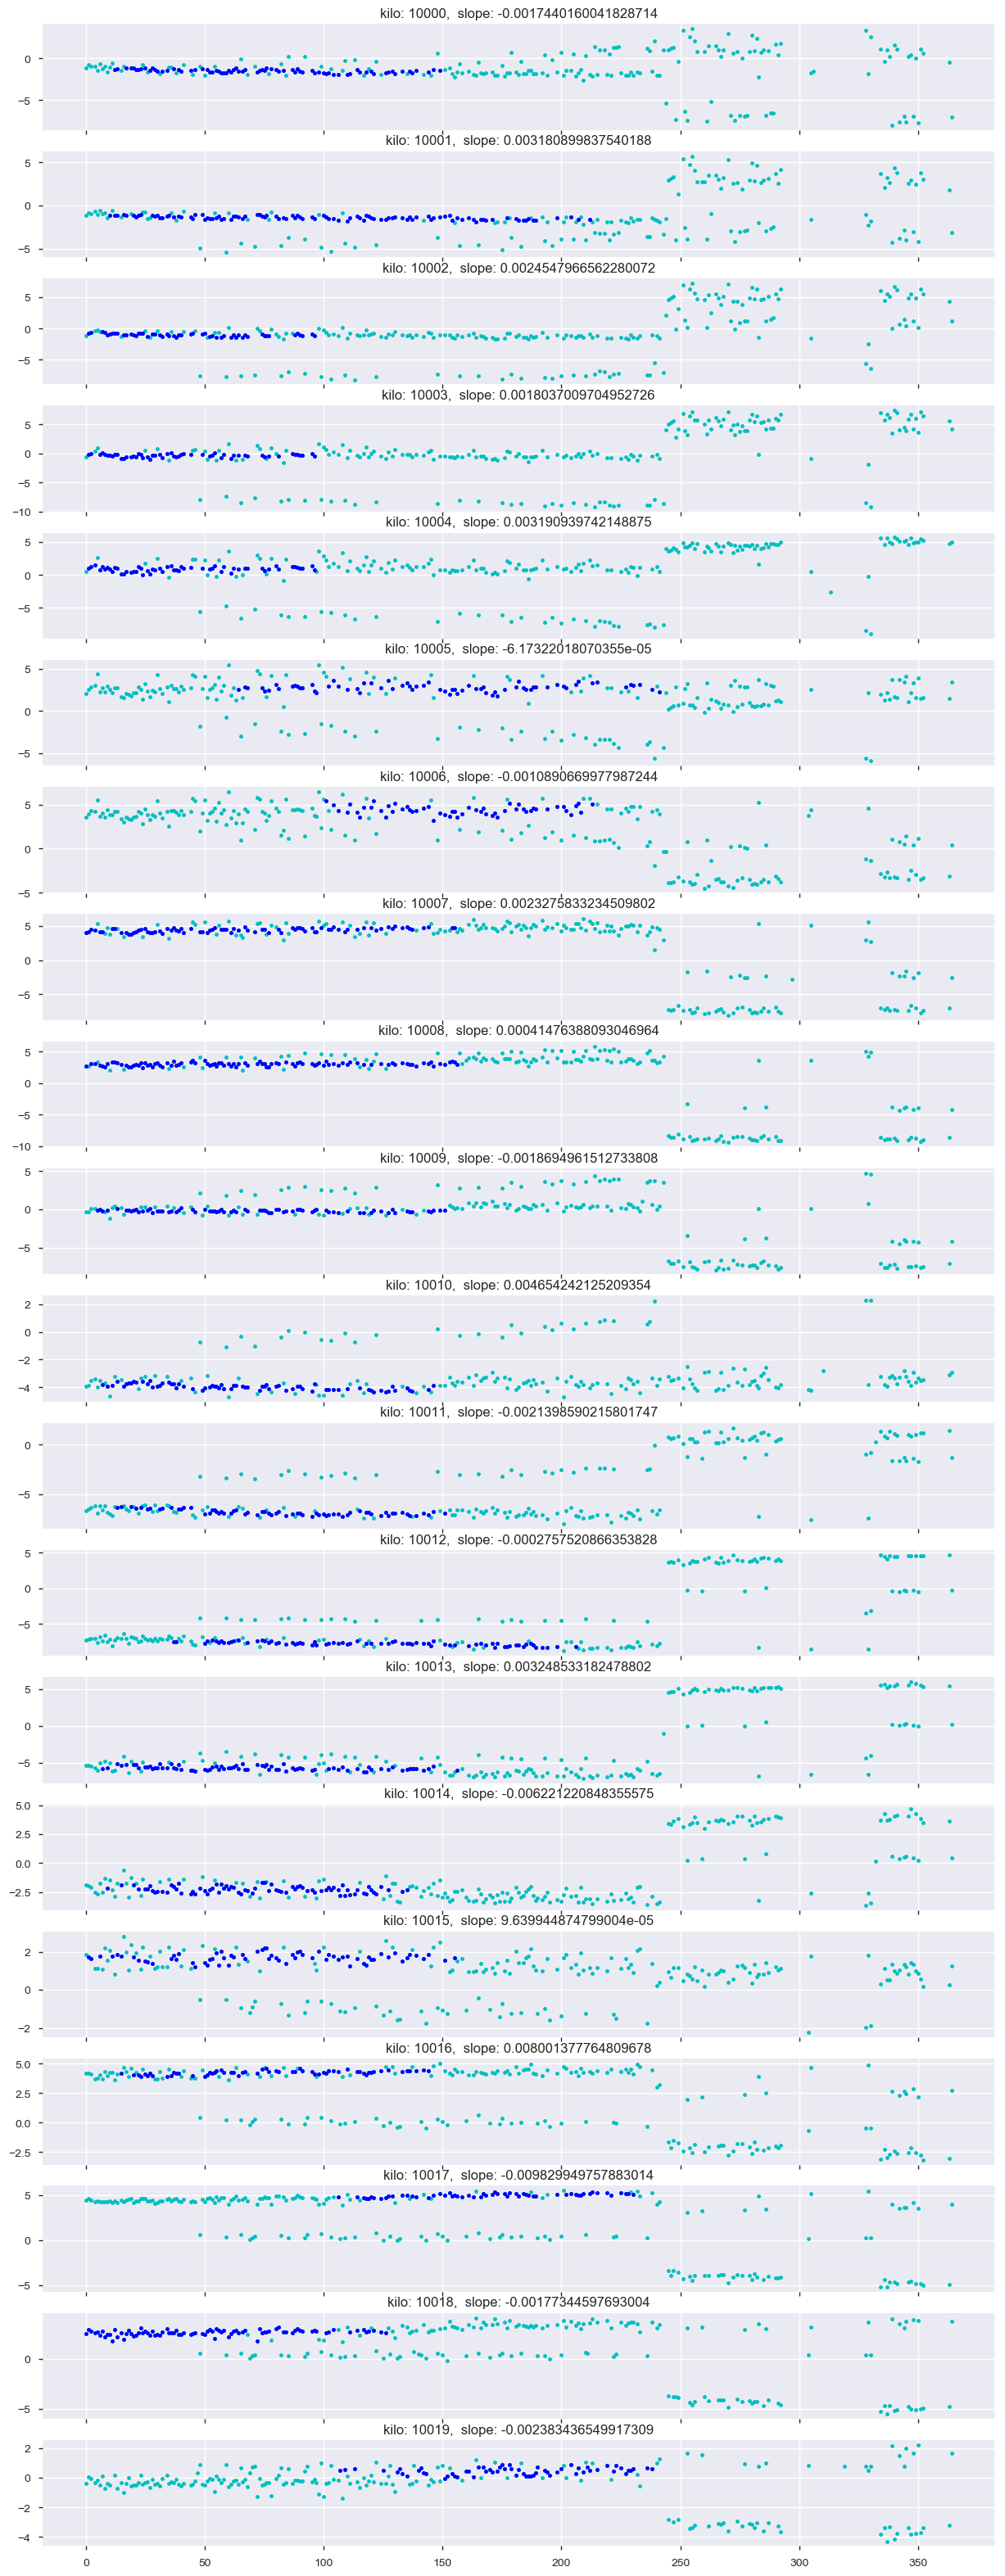

In [56]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()[:20]
for i, kilo in enumerate(kilos):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

#     kilo_id = kilo - 10000
#     hoge = [kilo_id + i*len(kilos) for i in range(91)]
#     piyo = submision.loc[hoge, 0]
#     axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  slope: {y_train[i]}')

<Figure size 1440x576 with 0 Axes>

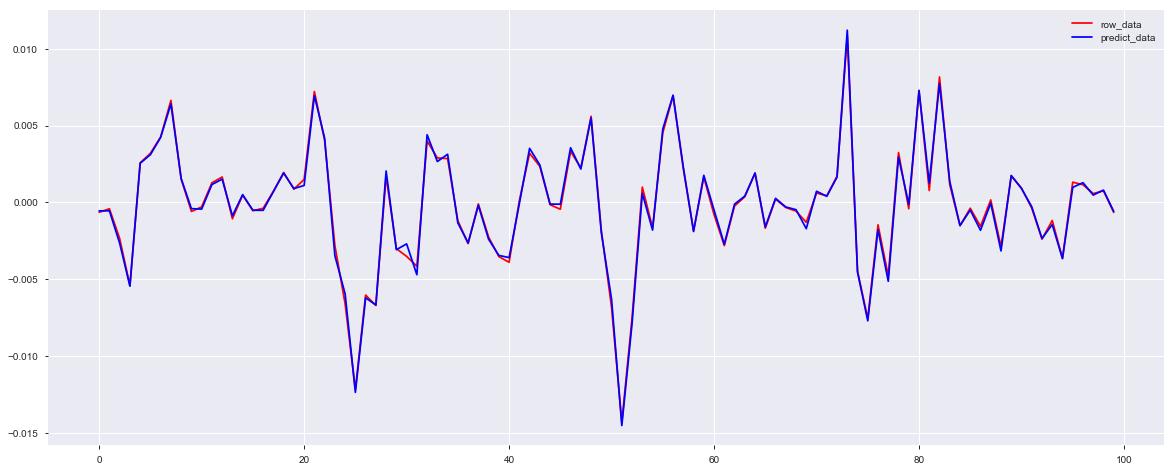

0.007099686373557964

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[300:400])), train_pred[300:400], color="r", label="row_data")
plt.plot(range(len(y_train[300:400])), y_train[300:400], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

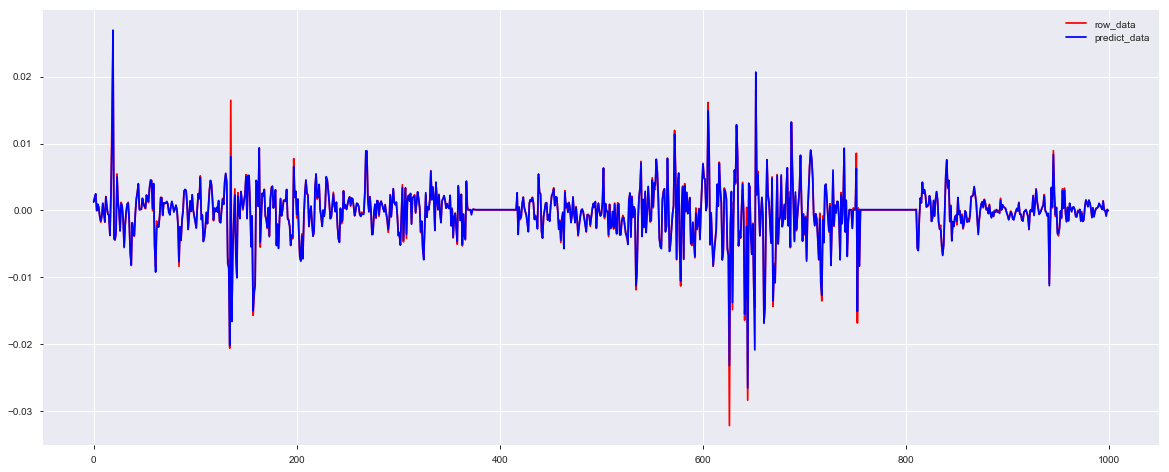

0.007099686373557964

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

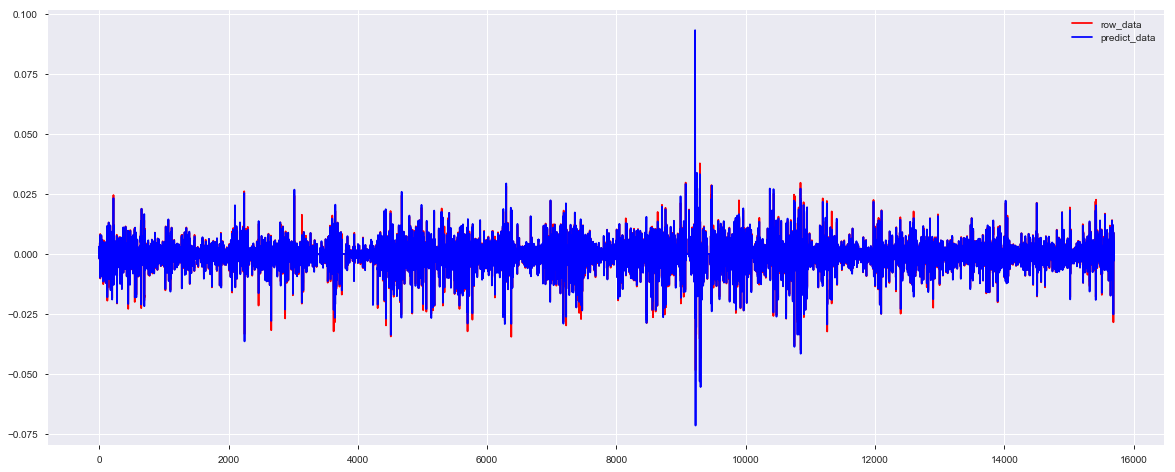

0.007099686373557964

In [34]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred, color="r", label="row_data")
plt.plot(range(len(y_train)), y_train, color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

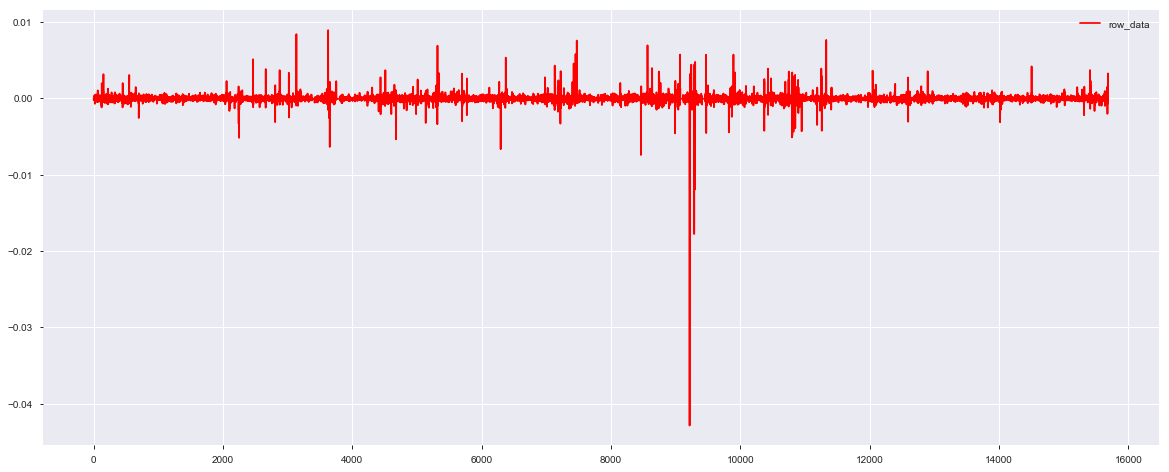

In [35]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), abs(train_pred)-abs(y_train), color="r", label="row_data")
plt.legend()
plt.show()

In [36]:
for no in ['A', 'B', 'C', 'D']:
    train = summarys[no]['傾き'].values
    train = pd.DataFrame({'slope': train})

    lag = train['slope'].shift(1)
    train['dif'] = train['slope'] - lag
    lag_inv = train['slope'].shift(-1)
    train['dif_inv'] = train['slope'] - lag_inv
    train['maen'] = (lag + lag_inv)*0.5

    X_train = train.drop(['slope'], axis=1).values
    y_train = train['slope'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary13_{no}.csv')

In [38]:
%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    summary = summarys[no]

    sub = pd.DataFrame()
    sub['キロ程'] = track['キロ程'].unique()
    sub['路線'] = no

    sub['傾き'] = summary['傾き'].values
    sub['切片'] = summary['切片'].values
    
    submit = pd.concat([submit, sub], axis=0)
submit = submit.reset_index(drop=True)

CPU times: user 920 ms, sys: 65.8 ms, total: 986 ms
Wall time: 997 ms


In [39]:
pdp.ProfileReport(summarys['A'])

Number of variables,7
Number of observations,27906
Total Missing (%),0.2%
Total size in memory,1.7 MiB
Average record size in memory,64.0 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [40]:
pdp.ProfileReport(submit)

Number of variables,4
Number of observations,120812
Total Missing (%),0.0%
Total size in memory,3.7 MiB
Average record size in memory,32.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [41]:
p = []
last_median_day = 30
for no in ['A', 'B', 'C', 'D']:
    tmp = submit[submit['路線'] == no]
    for i in range(91):
        day = tmp['切片'].values + tmp['傾き'].values*(i+last_median_day//2)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [42]:
submision.max()

0    19.03
dtype: float64

In [43]:
submision.min()

0   -18.25
dtype: float64

In [44]:
submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [45]:
submision.max()

0    16.0
dtype: float64

In [46]:
submision.min()

0   -16.0
dtype: float64

In [47]:
submision

,0
0,0.33
1,2.65
2,4.95
3,5.96
4,5.05
5,1.65
6,-3.18
7,-7.08
8,-8.83
9,-7.43


Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

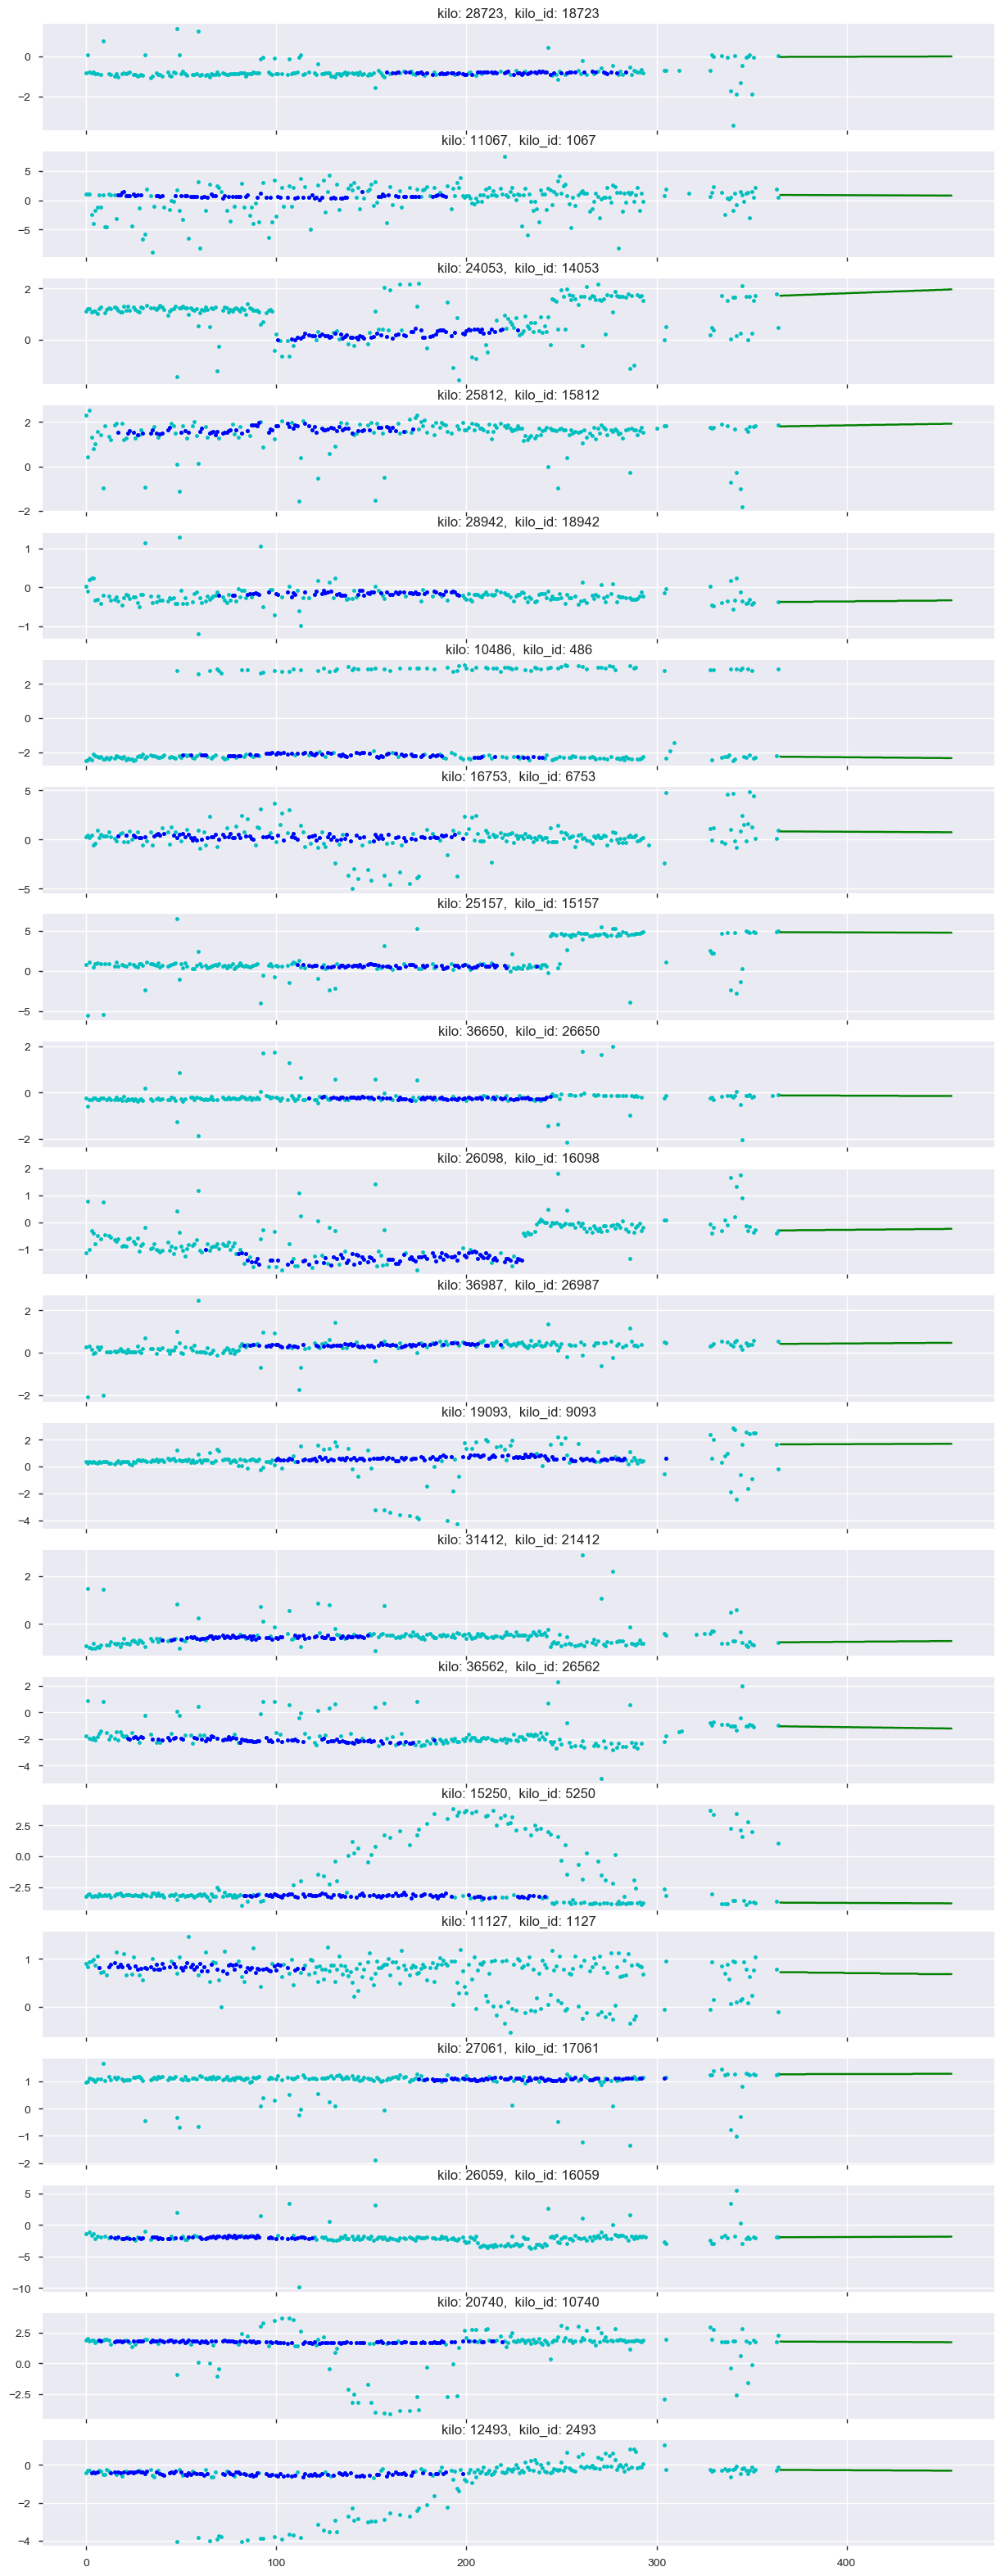

In [48]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

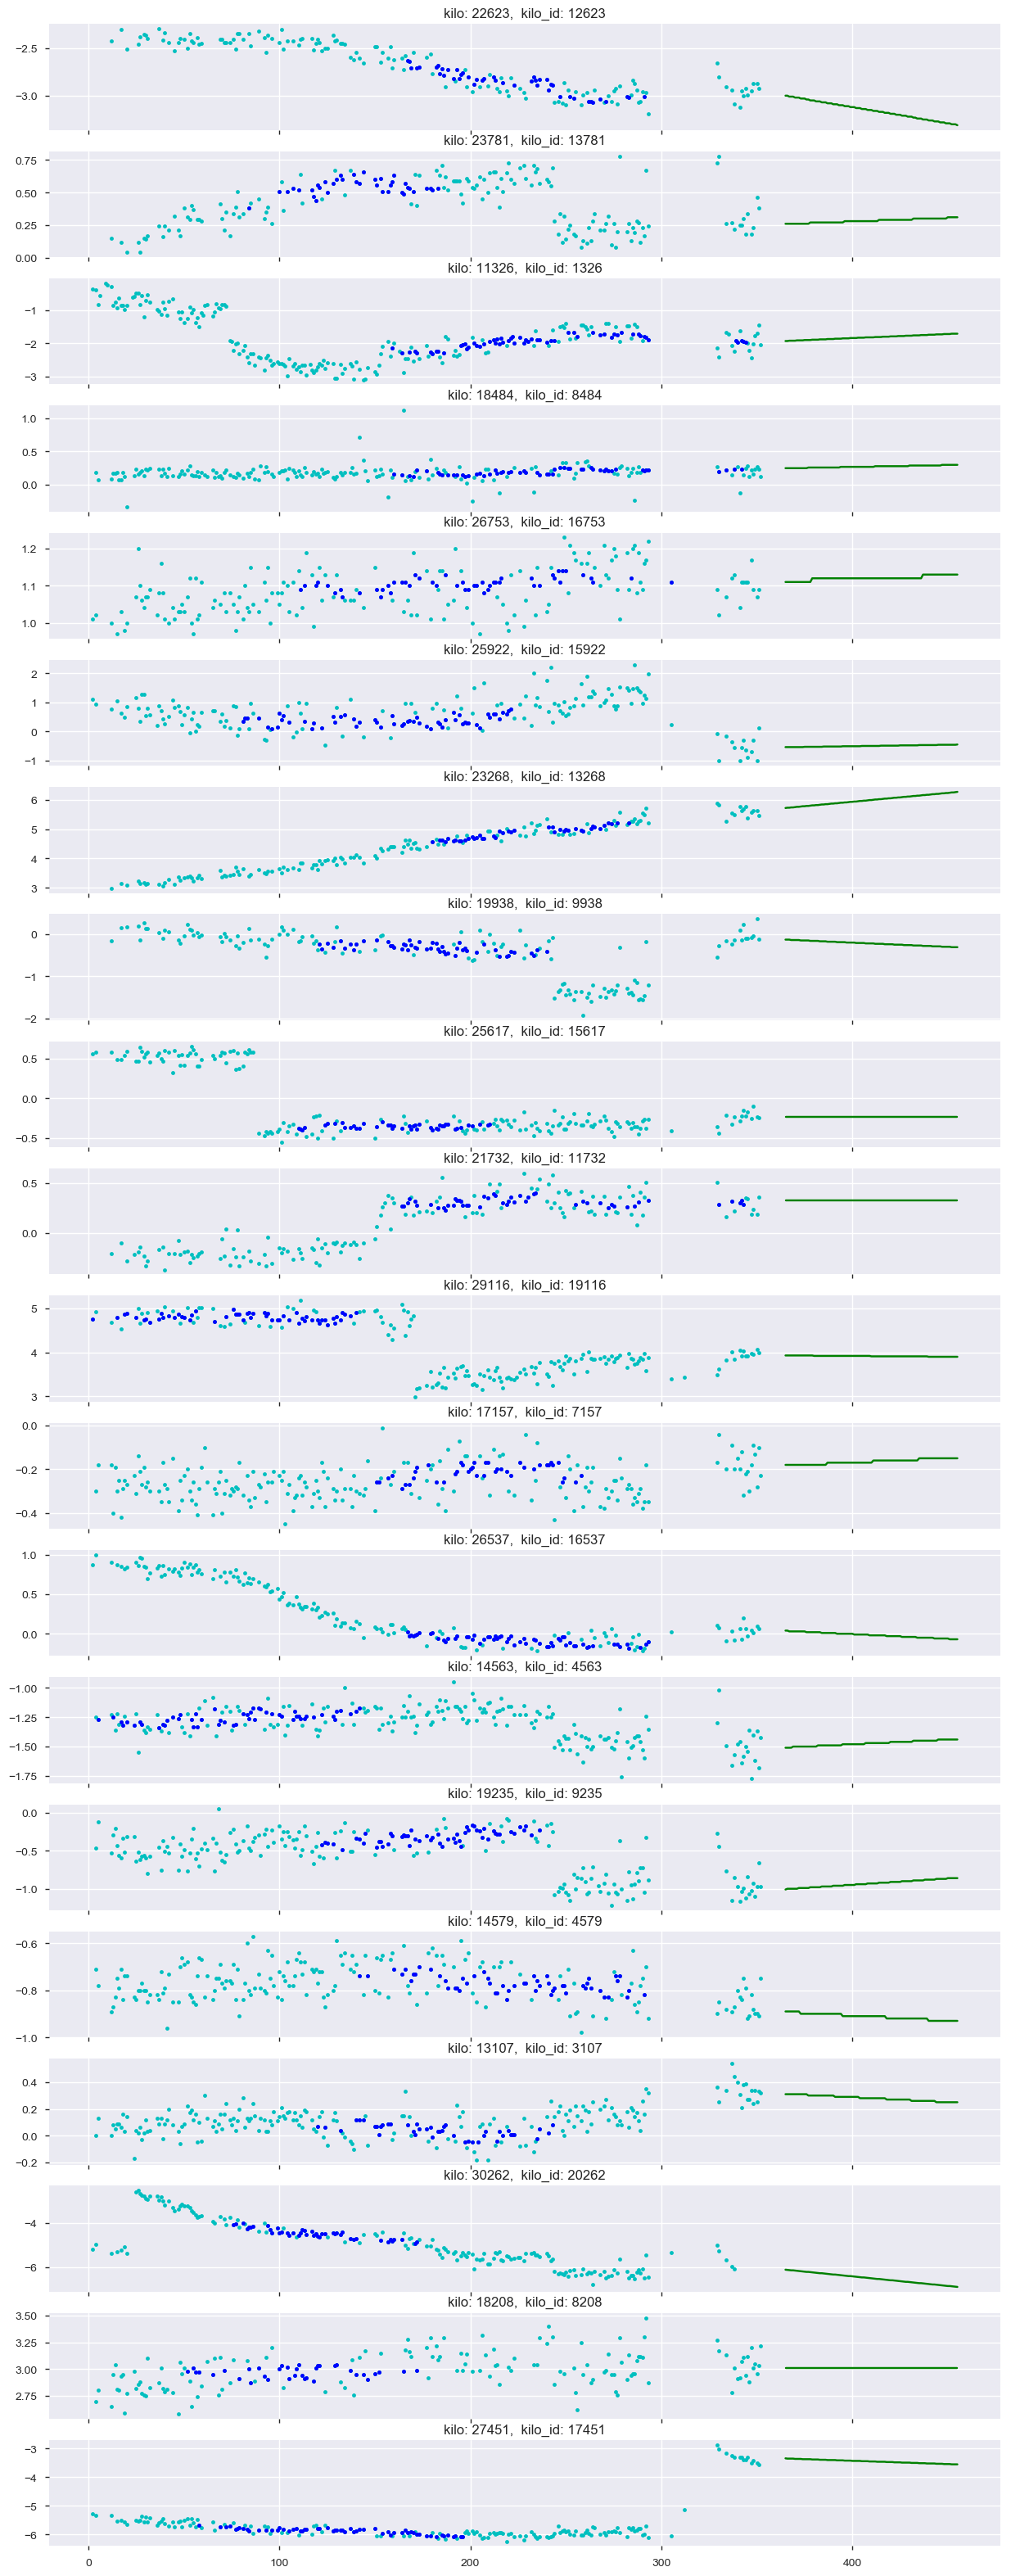

In [50]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')



    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

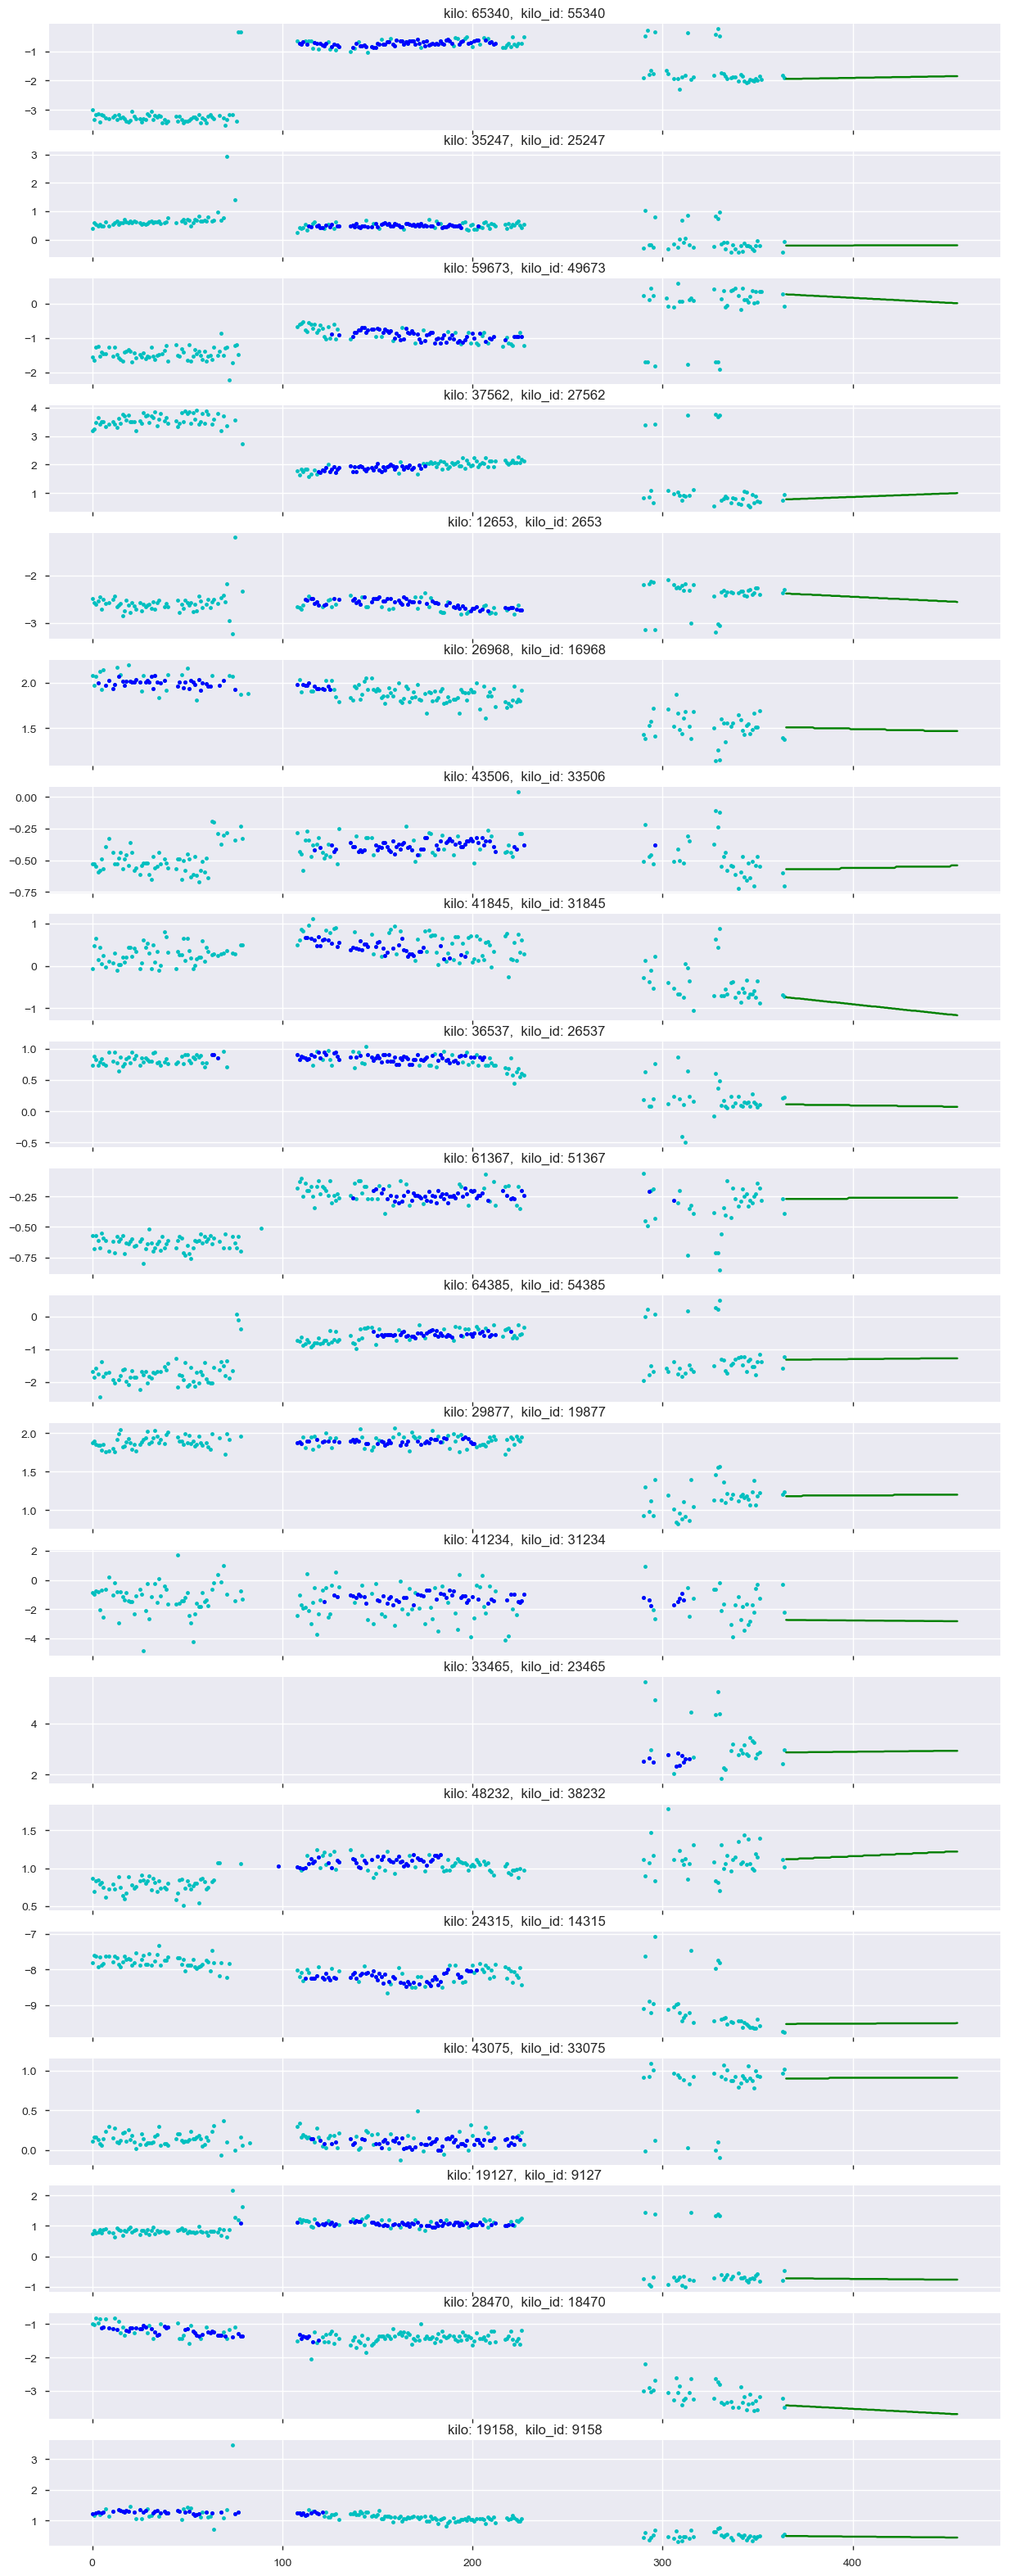

In [51]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

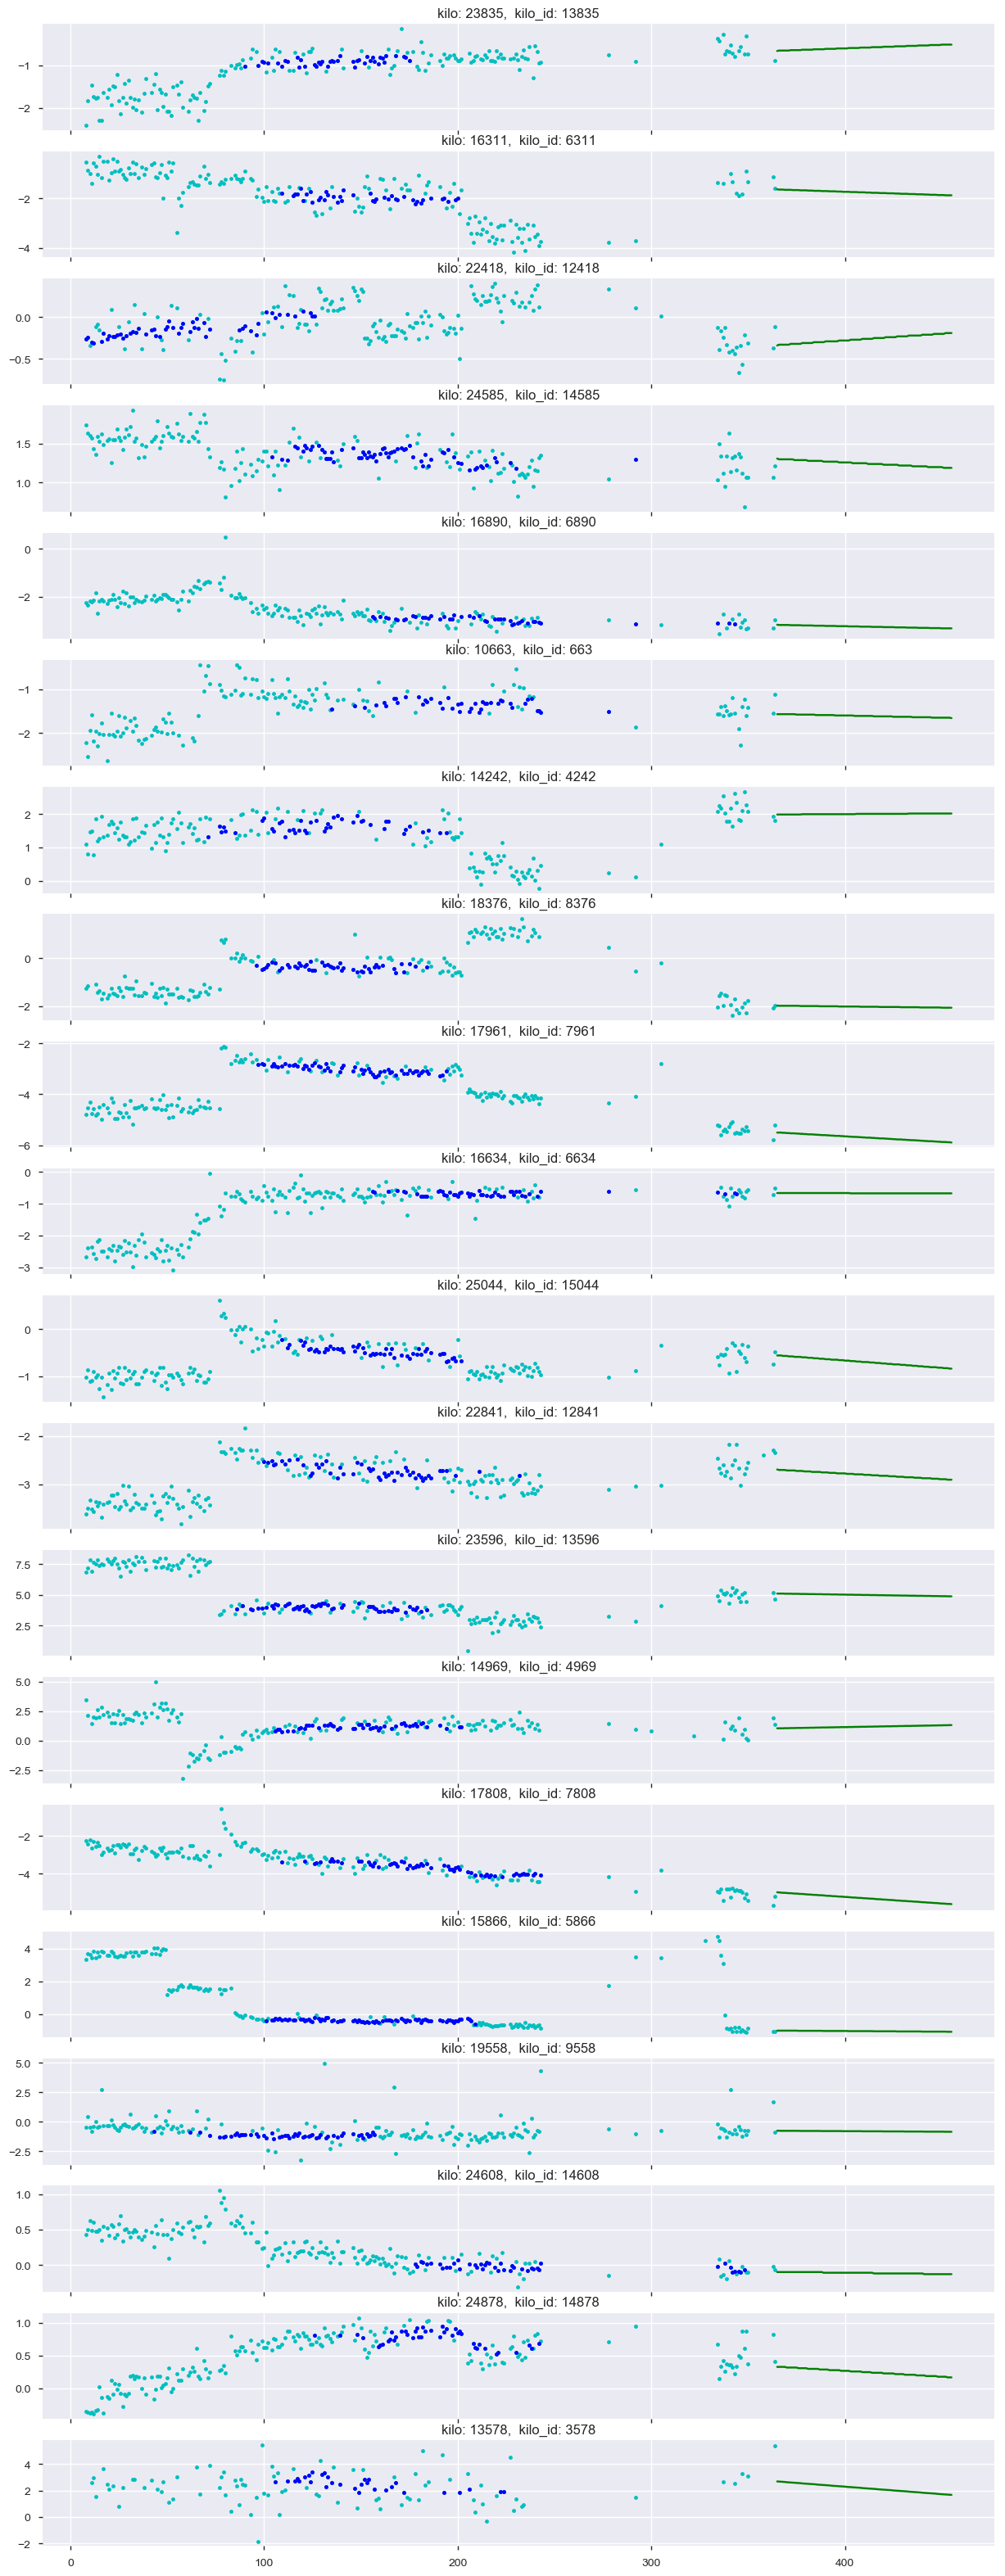

In [52]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [49]:
submision.to_csv("submit13.csv", header=None)